In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import re
import fasttext
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import display, HTML
import seaborn as sns
import urllib.request as urllib2
from bs4 import BeautifulSoup

## Data Cleaning

In [2]:
data = pd.read_csv("data.csv")

In [3]:
# train/valid/test = 0.8/0.1/0.1

def clean_text(text):
    cleaned_text = re.sub(r'[^A-Za-z0-9 ]+', '', text)
    return cleaned_text.lower()
    
def clean_instances(data):
    instances = data["sentence"]
    labels = data["is_instance"]
    
    labels = ["instance" if l else "not_instance" for l in labels]
    
    cleaned_instances = [clean_text(inst) for inst in instances]
    
    df_new = pd.DataFrame(columns = data.columns)
    df_new[data.columns] = data[data.columns]
    df_new["sentence"] = cleaned_instances
    
    df_new["is_instance"] = labels
    
    return df_new


data_clean = clean_instances(data)

train_text, truth_text, train_labels, truth_labels = train_test_split(data_clean["sentence"], data_clean["is_instance"], test_size = 0.1, shuffle = True)
train_text, test_text, train_labels, test_labels = train_test_split(train_text, train_labels, test_size = 1/9, shuffle = True)

train_text, test_text, truth_text = train_text.to_numpy(), test_text.to_numpy(), truth_text.to_numpy()
train_labels, test_labels, truth_labels = train_labels.to_numpy(), test_labels.to_numpy(), truth_labels.to_numpy()

In [4]:
fasttext_data_train = [f"__label__{train_labels[i]} {train_text[i]}" for i in range(len(train_labels))]
fasttext_data_test = [f"__label__{test_labels[i]} {test_text[i]}" for i in range(len(test_labels))]
fasttext_data_truth = [f"__label__{truth_labels[i]} {truth_text[i]}" for i in range(len(truth_labels))]

train_file = open("model.train", "w+")
test_file = open("model.valid", "w+")
truth_file = open("model.truth", "w+")

train_file.write("\n".join(fasttext_data_train))
test_file.write("\n".join(fasttext_data_test))
truth_file.write("\n".join(fasttext_data_truth))

train_file.close()
test_file.close()
truth_file.close()

## Parameter Selection

In [5]:
cv_data = []

for lr in np.arange(0, 1, 0.05):
    row = []
    for epochs in range(5, 35, 5):
        model_cv = fasttext.train_supervised(input = "model.train", lr = lr, epoch = epochs)
        p = model_cv.test("model.valid")[1]
        row.append(p)
    cv_data.append(row)

<AxesSubplot:>

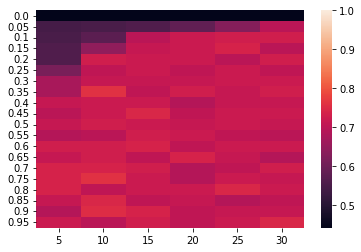

In [6]:
sns.heatmap(cv_data, vmin = np.min(cv_data), vmax = 1, xticklabels = np.arange(5, 35, 5), yticklabels = np.arange(0, 1, 0.05).round(3))

In [7]:
max_idx = np.unravel_index(np.array(cv_data).argmax(), np.array(cv_data).shape)
best_learning_rate = np.arange(0, 1, 0.05)[max_idx[0]]
best_epochs = np.arange(5, 35, 5)[max_idx[1]]
max_p = cv_data[max_idx[0]][max_idx[1]]

print(f"Best Learning Rate: {best_learning_rate}\nBest Number of Epochs: {best_epochs}\nMax Precision/Recall: {max_p}")

Best Learning Rate: 0.35000000000000003
Best Number of Epochs: 10
Max Precision/Recall: 0.7596899224806202


In [8]:
def create_confusion_mat(text, labels, m):
    
    df = pd.DataFrame(confusion_matrix([str(l) for l in labels], [m.predict(t)[0][0][len("__label__"):] for t in text]), index = ["Actual Not Instance", "Actual Instance"])
    df.columns = ["Predicted Not Instance", "Predicted Instance"]
                  
    return df

def print_precision_recall(filename, m):
    n, p, r = m.test(filename)
    print(f"Results for {filename}\nPrecision: {p} | Recall: {p}\n\n")

## Analyzing Results

In [9]:
model_cv = fasttext.train_supervised(input = "model.train", lr = best_learning_rate, epoch = best_epochs)

In [10]:
for fn in ["model.train", "model.valid", "model.truth"]:
    print_precision_recall(fn, model_cv)

Results for model.train
Precision: 0.9903100775193798 | Recall: 0.9903100775193798


Results for model.valid
Precision: 0.7209302325581395 | Recall: 0.7209302325581395


Results for model.truth
Precision: 0.7829457364341085 | Recall: 0.7829457364341085




In [11]:
display(HTML('<b>Training Data Confusion Matrix</b>'))
create_confusion_mat(train_text, train_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,537,1
Actual Instance,9,485


In [12]:
display(HTML('<b>Validation Data Confusion Matrix</b>'))
create_confusion_mat(test_text, test_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,55,17
Actual Instance,19,38


In [13]:
display(HTML('<b>Testing Data Confusion Matrix</b>'))
create_confusion_mat(truth_text, truth_labels, model_cv)

,Predicted Not Instance,Predicted Instance
Actual Not Instance,56,16
Actual Instance,12,45


## Predicting on the Web

In [14]:
def answer(url, tol):
    
    hdr = {'User-Agent': 'Mozilla/5.0'}
    req = urllib2.Request(url, headers = hdr)
    page = urllib2.urlopen(req)
    soup = BeautifulSoup(page, "html.parser")
    
    paragraphs_web = soup.findAll("p")
    paragraphs_web = [p.text for p in paragraphs_web]
    
    response = []

    for p in paragraphs_web:
        sentences = [s for s in nltk.sent_tokenize(p)]
        sentences_cleaned = [clean_text(s) for s in sentences]

        pred = [(model_cv.predict(s)[0][0][len("__label__"):] == 'instance', model_cv.predict(s)[1][0]) for s in sentences_cleaned]
        labels = ["I" if label and score > tol else "N" for label, score in pred]
        
        chunk_idxs = [(m.start(0), m.end(0)) for m in re.finditer("III*", "".join(labels))]
        
        chunks = []
        for start, end in chunk_idxs:
            if start == end:
                continue
            chunks.append(sentences[start:end])
        
        if len(chunks) > 0:
            chunk_text = [" ".join(c) for c in chunks]
            response.append(" ".join(chunk_text))
    
        
    return "\n\n".join(response)

In [21]:
print(answer("https://www.dataversity.net/a-brief-history-of-machine-learning/", 0.9))

An artificial neural network (ANN) has hidden layers which are used to respond to more complicated tasks than the earlier perceptrons could. ANNs are a primary tool used for machine learning.

The industry goal shifted from training for artificial intelligence to solving practical problems in terms of providing services. Its focus shifted from the approaches inherited from AI research to methods and tactics used in probability theory and statistics.

3D face scans, iris images, and high-resolution face images were tested. Their findings suggested the new algorithms were ten times more accurate than the facial recognition algorithms from 2002 and 100 times more accurate than those from 1995.

Google is currently experimenting with machine learning using an approach called instruction fine-tuning. The goal is to train an ML model  to resolve natural language processing issues in a generalized way.


In [25]:
print(answer("https://www.forbes.com/sites/bernardmarr/2016/02/19/a-short-history-of-machine-learning-every-manager-should-read/?sh=2474976115e7", 0.7))

It’s all well and good to ask if androids dream of electric sheep, but science fact has evolved to a point where it’s beginning to coincide with science fiction. No, we don’t have autonomous androids struggling with existential crises — yet — but we are getting ever closer to what people tend to call “artificial intelligence.”

1967 — The “nearest neighbor” algorithm was written, allowing computers to begin using very basic pattern recognition. This could be used to map a route for traveling salesmen, starting at a random city but ensuring they visit all cities during a short tour.

2016 – Google’s artificial intelligence algorithm beats a professional player at the Chinese board game Go, which is considered the world’s most complex board game and is many times harder than chess. The AlphaGo algorithm developed by Google DeepMind managed to win five games out of five in the Go competition.


In [26]:
print(answer("https://concisesoftware.com/history-of-machine-learning/", 0.8))

In order to pass the test, the computer needs to be able to convince a human to believe that it’s another human. Apart from a computer program simulating a 13-year-old Ukrainian boy who is said to have passed the Turing test, there were no other successful attempts so far.

Today, the nearest neighbor algorithm called KNN is mostly used to classify a data point on the basis of how their neighbors are classified. KNN is used in retail applications that recognize patterns in credit card usage or for theft prevention when implemented in CCTV image recognition in retail stores.

2010 – this year saw the introduction of Microsoft Kinect that could track even 20 human features at the rate of 30 times per second. Microsoft Kinect allowed users to interact with machines via gestures and movements.

We are excited to build relationships with people who want to change the world. Contact us:
